In [1]:
import sys
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import librosa
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import cv2
import torch
#import torchaudio

from tools import prepare, mixup, preprocess, noise, getCorrects

sys.path.append('../BAT/datasets/')

classes = {
    "Rhinolophus ferrumequinum": 0,
    "Rhinolophus hipposideros": 1,
    "Myotis daubentonii": 2,
    "Myotis brandtii": 3,
    "Myotis mystacinus": 4,
    "Myotis emarginatus": 5,
    "Myotis nattereri": 6,
    #"Myotis bechsteinii": 7,
    "Myotis myotis": 7,
    "Myotis dasycneme": 8,
    "Nyctalus noctula": 9,
    "Nyctalus leisleri": 10,
    "Pipistrellus pipistrellus": 11,
    "Pipistrellus nathusii": 12,
    "Pipistrellus kuhlii": 13,
    "Eptesicus serotinus": 14,
    "Eptesicus nilssonii": 15,
    #"Plecotus auritus": 16,
    #"Plecotus austriacus": 16,
    #"Barbastella barbastellus": 16,
    #"Tadarida teniotis": 16,
    "Miniopterus schreibersii": 16,
    #"Hypsugo savii": 18,
    "Vespertilio murinus": 17,
}

2023-01-12 14:46:53.526040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 14:46:53.961738: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-12 14:46:56.797073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ffundel/.local/lib:
2023-01-12 14:46:56.797382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

# Dataset

In [2]:
nfft = 512
num_bands = nfft // 2 + 1

max_len = 60
patch_len = 44
patch_skip = 22

samples_per_step = patch_skip * (nfft // 4)
seq_len = (max_len + 1) * samples_per_step
seq_skip = (max_len + 1) * samples_per_step // 4
    
data_path = "../BAT/datasets/prepared_signal.h5"
X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare(data_path, classes, seq_len, seq_skip)

100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 20.00it/s]


In [3]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print("Train sequences:", X_train.shape, Y_train.shape)
print("Test sequences:", X_test.shape, Y_test.shape)
print("Validation sequences:", X_val.shape, Y_val.shape)

Total sequences: 19030
Train sequences: torch.Size([11186, 171776]) torch.Size([11186, 18])
Test sequences: torch.Size([4954, 171776]) torch.Size([4954, 18])
Validation sequences: torch.Size([2890, 171776]) torch.Size([2890, 18])


In [4]:
# Holdout for unsupervised training
holdout = True
if holdout:
    h_split = 0.9
    h_train = int(len(X_train) * h_split)
    
    X_train = X_train[h_train:]
    Y_train = Y_train[h_train:]

In [5]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print("Train sequences:", X_train.shape, Y_train.shape)
print("Test sequences:", X_test.shape, Y_test.shape)
print("Validation sequences:", X_val.shape, Y_val.shape)

Total sequences: 7956
Train sequences: torch.Size([112, 171776]) torch.Size([112, 18])
Test sequences: torch.Size([4954, 171776]) torch.Size([4954, 18])
Validation sequences: torch.Size([2890, 171776]) torch.Size([2890, 18])


# Model

In [6]:
import time
import datetime
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader

from torchsummary import summary
from torchmetrics.functional import f1_score

from SAM import SAM
from ASL import AsymmetricLoss
from BigBAT import BigBAT

/home/ffundel/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ffundel/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])

In [8]:
from torchsummary import summary

patch_embedding = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(5, 7), stride=(2, 3), padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2, padding=1),

            nn.Conv2d(32, 64, kernel_size=(3, 5), stride=(1, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ).to(device)

big_patch_embedding = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 5), stride=(2, 3), padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=5, stride=2, padding=1),

            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
    
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ).to(device)

summary(big_patch_embedding, (1, 44, 257))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 87]             256
       BatchNorm2d-2           [-1, 16, 24, 87]              32
              ReLU-3           [-1, 16, 24, 87]               0
            Conv2d-4           [-1, 32, 14, 30]           7,712
       BatchNorm2d-5           [-1, 32, 14, 30]              64
              ReLU-6           [-1, 32, 14, 30]               0
         MaxPool2d-7            [-1, 32, 7, 15]               0
            Conv2d-8             [-1, 32, 4, 5]           9,248
       BatchNorm2d-9             [-1, 32, 4, 5]              64
             ReLU-10             [-1, 32, 4, 5]               0
           Conv2d-11             [-1, 64, 2, 2]          18,496
      BatchNorm2d-12             [-1, 64, 2, 2]             128
             ReLU-13             [-1, 64, 2, 2]               0
           Conv2d-14             [-1, 6

In [9]:
batch_size = 64
epochs = 46
lr = 0.0005
warmup_epochs = 5
d_model = 64

nhead = 2
dim_feedforward = 32
num_layers = 2
dropout = 0.3
classifier_dropout = 0.3
num_classes = len(list(classes))
    
model = BigBAT(
    max_len=max_len,
    patch_len=patch_len,
    patch_skip=patch_skip,
    d_model=d_model,
    num_classes=len(list(classes)),
    patch_embedding=big_patch_embedding,
    use_cls=False,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    dropout=dropout,
    classifier_dropout=classifier_dropout,
)
    
model.to(device)
print(device)

cuda:0


In [10]:
## This is the unsupervised pretraining section
## Here we initialize the model by loading weights from a unsupervised model

unsup_type = 'none' # choose from 'none' 'skiba_pre', 'ae_full', 'ae_full2'

# choose from 'BigBAT-petrain.pth', 'BigBAT_skiba_pretrained.pth', 'BigBAT-SimCLR.pth'
pretrained_dict = torch.load('BigBAT-BYOL.pth') #pretrained model keys
model_dict = model.state_dict() #new model keys
processed_dict = {}
    
if unsup_type == 'ae_full':
    model.load_state_dict(pretrained_dict)
    
elif unsup_type == 'ae_full2':
    remove_component = "patch_embedding"
    for k in pretrained_dict.keys(): 
        decomposed_key = k.split(".")
        if remove_component in decomposed_key:
            processed_dict[k] = model_dict[k]
        else:
            processed_dict[k] = pretrained_dict[k]
    print(processed_dict.keys())
    model.load_state_dict(processed_dict)
    
elif unsup_type == 'skiba_pre':
    pretrained_dict = torch.load('BigBAT-skiba-pretrained.pth')
    for k in pretrained_dict.keys(): 
        processed_dict[k.replace("to_patch_embedding", "patch_embedding")] = pretrained_dict[k]
    model.load_state_dict(processed_dict)
    
else:
    pass

In [11]:
#freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=50)
#time_masking = torchaudio.transforms.TimeMasking(time_mask_param=50)

In [12]:
train_len = batch_size * int(len(X_train) / batch_size)
test_len = batch_size * int(len(X_test) / batch_size)
val_len = batch_size * int(len(X_val) / batch_size)

train_data = TensorDataset(X_train[:train_len], Y_train[:train_len])
test_data = TensorDataset(X_test[:test_len], Y_test[:test_len])
val_data = TensorDataset(X_val[:val_len], Y_val[:val_len])

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

(1343, 257)


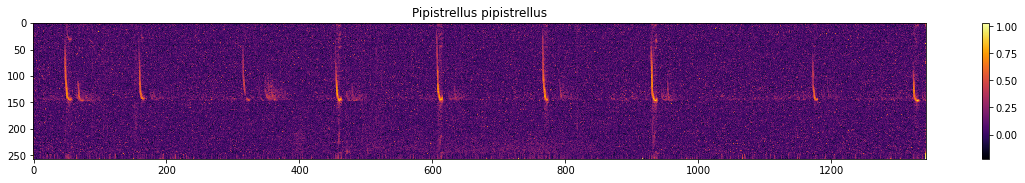

In [13]:
def plot_sequence(X, Y, k):
    plt.figure(figsize = (20, 2.5))
    x = X[k].cpu().detach().numpy()
    y = Y[k].cpu().detach().numpy()
    plt.imshow(np.rot90(x), interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    label_list = []
    if(len(y.shape) > 0):
        for i in np.argwhere(y == 1)[:,0]:
            label_list.append(list(classes)[i])
        plt.title(", ".join(label_list))
    else:
        plt.title(list(classes)[y])
    print(x.shape)

k = np.random.randint(0, batch_size)
X1, Y1 = next(iter(train_loader))
X1, Y1 = X1.cuda(), Y1.cuda()
X1, Y1 = mixup(X1, Y1, min_seq=1, max_seq=3)
X1 = preprocess(X1)
X1 = noise(X1)
#X1 = freq_masking(X1)
#X1 = time_masking(X1)
        
plot_sequence(X1, Y1, k)

In [14]:
criterion = AsymmetricLoss(gamma_neg=2, gamma_pos=1, clip=0)

#base_optimizer = torch.optim.SGD
#optimizer = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4, nesterov=True, dampening=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=warmup_epochs)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.97)

min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

In [15]:
def smoothen(y, num_classes, l=.02):
    return y * (1.0 - l) + (y.sum(dim=1, keepdim=True) * l / num_classes).repeat(1, num_classes)

def getSpeciesMasks(species):
    masks = torch.eye(len(species))
    for i, s in enumerate(species):
        genus = s.split(' ')[0]
        for k, ss in enumerate(species):
            if ss.startswith(genus):
                masks[i, k] = 1
        masks[i, i] = 0
    return masks

def speciesSmoothing(Y, masks, l=.1):
    ny = torch.zeros_like(Y)
    for i, y in enumerate(Y):
        lbl = torch.nonzero(y)
        ny[i] = y * (1.0 - l) + masks[lbl].sum(0) * (y.sum() * l / max(masks[lbl].sum(), 1))
    return ny

test_y = torch.zeros(3, num_classes).to(device)
test_y[0, 4] = 1
test_y[0, 5] = 1
test_y[1, 11] = 1
test_y[2, 4] = 1
test_y[2, 11] = 1
test_y[2, 17] = 1
print(test_y)
masks = getSpeciesMasks(list(classes)).to(device)
test_smooth = smoothen(test_y, num_classes)
test_specsmooth = speciesSmoothing(test_y, masks)
print(test_smooth, test_smooth.sum())
print(test_specsmooth, test_specsmooth.sum())

tensor([[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]],
       device='cuda:0')
tensor([[0.0022, 0.0022, 0.0022, 0.0022, 0.9822, 0.9822, 0.0022, 0.0022, 0.0022,
         0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022],
        [0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
         0.0011, 0.0011, 0.9811, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011],
        [0.0033, 0.0033, 0.0033, 0.0033, 0.9833, 0.0033, 0.0033, 0.0033, 0.0033,
         0.0033, 0.0033, 0.9833, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.9833]],
       device='cuda:0') tensor(6., device='cuda:0')
tensor([[0.0000, 0.0000, 0.0333, 0.0333, 0.9167, 0.9167, 0.0333, 0.0333, 0.0333,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000,

In [16]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, min_seq=1, max_seq=3, p_min=0.3)
        inputs = preprocess(inputs)
         
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(inputs)

        # Compute Loss (ASL)
        loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights (SAM)
        optimizer.step()
        #optimizer.first_step()
        #criterion(model(inputs), labels).backward()
        #optimizer.second_step()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
        running_corrects += getCorrects(outputs, labels)
    
        # Perform learning rate step
        scheduler.step(epoch + batch / num_batches)
        #scheduler.step()
            
    epoch_loss = running_loss / num_samples
    epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [17]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = mixup(inputs, labels, min_seq=1, max_seq=3)
            inputs = preprocess(inputs)

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            running_corrects += getCorrects(outputs, labels)

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

# Training

In [18]:
import wandb

wandb_config = {
    "epochs": epochs,
    "lr": lr,
    "batch_size": batch_size,
    "warmup_epochs": warmup_epochs,
    "d_model": d_model,
    "nhead": nhead,
    "dim_feedforward": dim_feedforward,
    "num_layers": num_layers,
    "dropout": dropout,
    "classifier_dropout": classifier_dropout
}

wandb.init(project="BigBAT", entity="frankfundel", config=wandb_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frankfundel (use `wandb login --relogin` to force relogin)
2023-01-12 14:47:48.245861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 14:47:48.744237: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-12 14:47:50.642165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory

In [19]:
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss, train_acc = train_epoch(model, epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc), flush=True)
    
    val_loss, val_acc = test_epoch(model, epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc), flush=True)
    
    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
        
        # Saving State Dict
        torch.save(model.state_dict(), 'BigBAT.pth')

==================== Starting at epoch 0 ====================


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s]

Training loss: 139.2294 Acc: 0.1703



100%|███████████████████████████████████████████| 90/90 [00:18<00:00,  4.97it/s]

Validation loss: 123.8868 Acc: 0.2133
val_loss decreased, saving model
==================== Starting at epoch 1 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.07it/s]

Training loss: 118.8330 Acc: 0.1557



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.09it/s]

Validation loss: 102.6367 Acc: 0.2138
val_loss decreased, saving model
==================== Starting at epoch 2 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.24it/s]

Training loss: 100.5137 Acc: 0.0998



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.20it/s]

Validation loss: 90.3152 Acc: 0.0000
val_loss decreased, saving model
==================== Starting at epoch 3 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.14it/s]

Training loss: 90.9133 Acc: 0.0920



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.14it/s]


Validation loss: 86.3593 Acc: 0.0000
val_loss decreased, saving model
==================== Starting at epoch 4 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.11it/s]

Training loss: 89.1076 Acc: 0.0625



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.10it/s]

Validation loss: 85.8738 Acc: 0.0000
val_loss decreased, saving model
==================== Starting at epoch 5 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.08it/s]

Training loss: 84.9014 Acc: 0.0729



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.05it/s]


Validation loss: 81.4154 Acc: 0.0000
val_loss decreased, saving model
==================== Starting at epoch 6 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.09it/s]

Training loss: 75.9731 Acc: 0.0399



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.06it/s]

Validation loss: 77.0803 Acc: 0.0000
val_loss decreased, saving model
==================== Starting at epoch 7 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.14it/s]

Training loss: 67.0715 Acc: 0.0382



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.04it/s]

Validation loss: 75.7708 Acc: 0.0000
val_loss decreased, saving model
==================== Starting at epoch 8 ====================



100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.77it/s]

Training loss: 64.9728 Acc: 0.0312



100%|███████████████████████████████████████████| 90/90 [00:19<00:00,  4.68it/s]

Validation loss: 76.3822 Acc: 0.0000
==================== Starting at epoch 9 ====================



100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]

Training loss: 64.9079 Acc: 0.0278



100%|███████████████████████████████████████████| 90/90 [00:19<00:00,  4.67it/s]

Validation loss: 77.4285 Acc: 0.0000
==================== Starting at epoch 10 ====================



100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]

Training loss: 68.0250 Acc: 0.0399



100%|███████████████████████████████████████████| 90/90 [00:18<00:00,  4.79it/s]


Validation loss: 77.6568 Acc: 0.0000
==================== Starting at epoch 11 ====================


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s]

Training loss: 63.0650 Acc: 0.0538



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.10it/s]

Validation loss: 76.7979 Acc: 0.0000
==================== Starting at epoch 12 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.12it/s]

Training loss: 61.0923 Acc: 0.0556



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.07it/s]

Validation loss: 77.4251 Acc: 0.0000
==================== Starting at epoch 13 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.09it/s]

Training loss: 60.7500 Acc: 0.0764



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.02it/s]

Validation loss: 77.2586 Acc: 0.0000
==================== Starting at epoch 14 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.11it/s]

Training loss: 58.6499 Acc: 0.0712



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.08it/s]

Validation loss: 76.9872 Acc: 0.0000
==================== Starting at epoch 15 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.10it/s]

Training loss: 59.4984 Acc: 0.0521



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.10it/s]


Validation loss: 76.8854 Acc: 0.0055
==================== Starting at epoch 16 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.14it/s]

Training loss: 55.8991 Acc: 0.0781



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.10it/s]

Validation loss: 75.2520 Acc: 0.0112


val_loss decreased, saving model
==================== Starting at epoch 17 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.10it/s]

Training loss: 53.8759 Acc: 0.0955



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.07it/s]


Validation loss: 73.4925 Acc: 0.0205
val_loss decreased, saving model
==================== Starting at epoch 18 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.09it/s]

Training loss: 56.4534 Acc: 0.1007



100%|███████████████████████████████████████████| 90/90 [00:18<00:00,  4.95it/s]

Validation loss: 71.8809 Acc: 0.0315
val_loss decreased, saving model
==================== Starting at epoch 19 ====================



100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]

Training loss: 58.0025 Acc: 0.0938



100%|███████████████████████████████████████████| 90/90 [00:18<00:00,  4.86it/s]


Validation loss: 70.7623 Acc: 0.0343
val_loss decreased, saving model
==================== Starting at epoch 20 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.13it/s]

Training loss: 54.0661 Acc: 0.1372



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.18it/s]


Validation loss: 68.6741 Acc: 0.0533
val_loss decreased, saving model
==================== Starting at epoch 21 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.17it/s]

Training loss: 56.0030 Acc: 0.1354



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.14it/s]


Validation loss: 67.1944 Acc: 0.0664
val_loss decreased, saving model
==================== Starting at epoch 22 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.11it/s]

Training loss: 55.4200 Acc: 0.1389



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.12it/s]

Validation loss: 65.9043 Acc: 0.0689
val_loss decreased, saving model
==================== Starting at epoch 23 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.15it/s]

Training loss: 56.4932 Acc: 0.1267



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.13it/s]

Validation loss: 63.7414 Acc: 0.0827
val_loss decreased, saving model


==================== Starting at epoch 24 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.07it/s]

Training loss: 57.1605 Acc: 0.1424



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.12it/s]


Validation loss: 63.6586 Acc: 0.0773
val_loss decreased, saving model
==================== Starting at epoch 25 ====================


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s]

Training loss: 55.5264 Acc: 0.1094



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.15it/s]

Validation loss: 62.5433 Acc: 0.0693


val_loss decreased, saving model
==================== Starting at epoch 26 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.18it/s]

Training loss: 50.8769 Acc: 0.1753



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.14it/s]


Validation loss: 61.5287 Acc: 0.0708
val_loss decreased, saving model
==================== Starting at epoch 27 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.13it/s]

Training loss: 54.7930 Acc: 0.1181



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.21it/s]


Validation loss: 61.6071 Acc: 0.0730
==================== Starting at epoch 28 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.14it/s]

Training loss: 52.0845 Acc: 0.1736



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.12it/s]

Validation loss: 61.0411 Acc: 0.0755


val_loss decreased, saving model
==================== Starting at epoch 29 ====================


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]

Training loss: 53.7069 Acc: 0.1354



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.11it/s]

Validation loss: 61.9189 Acc: 0.0664
==================== Starting at epoch 30 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.16it/s]

Training loss: 53.3390 Acc: 0.1233



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.11it/s]

Validation loss: 61.2597 Acc: 0.0751
==================== Starting at epoch 31 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.15it/s]

Training loss: 51.0879 Acc: 0.1962



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.15it/s]

Validation loss: 59.3189 Acc: 0.0953
val_loss decreased, saving model
==================== Starting at epoch 32 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.09it/s]

Training loss: 53.8741 Acc: 0.2014



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.11it/s]


Validation loss: 60.4116 Acc: 0.0968
==================== Starting at epoch 33 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.21it/s]

Training loss: 53.4209 Acc: 0.2205



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.13it/s]

Validation loss: 60.3120 Acc: 0.1004
==================== Starting at epoch 34 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.08it/s]

Training loss: 49.2591 Acc: 0.2170



100%|███████████████████████████████████████████| 90/90 [00:18<00:00,  4.83it/s]

Validation loss: 59.4798 Acc: 0.0964
==================== Starting at epoch 35 ====================



100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.79it/s]

Training loss: 51.2942 Acc: 0.2014



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.05it/s]

Validation loss: 60.6559 Acc: 0.1017
==================== Starting at epoch 36 ====================



100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]

Training loss: 51.6805 Acc: 0.1944



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.01it/s]

Validation loss: 62.8210 Acc: 0.1029
==================== Starting at epoch 37 ====================



100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.88it/s]

Training loss: 51.5834 Acc: 0.2135



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.07it/s]

Validation loss: 61.9858 Acc: 0.1130


==================== Starting at epoch 38 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.08it/s]

Training loss: 51.1333 Acc: 0.1892



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.09it/s]


Validation loss: 61.6953 Acc: 0.1225
==================== Starting at epoch 39 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.16it/s]

Training loss: 50.6521 Acc: 0.1632



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.10it/s]

Validation loss: 60.6766 Acc: 0.1164
==================== Starting at epoch 40 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.11it/s]

Training loss: 53.1482 Acc: 0.1562



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.04it/s]

Validation loss: 60.6422 Acc: 0.0987
==================== Starting at epoch 41 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.14it/s]

Training loss: 49.1776 Acc: 0.2465



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.07it/s]

Validation loss: 60.1225 Acc: 0.1031


==================== Starting at epoch 42 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.16it/s]

Training loss: 50.6030 Acc: 0.2378



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.14it/s]

Validation loss: 59.3064 Acc: 0.1033
val_loss decreased, saving model
==================== Starting at epoch 43 ====================



100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.09it/s]

Training loss: 52.5116 Acc: 0.2517



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.13it/s]

Validation loss: 59.1484 Acc: 0.1111


val_loss decreased, saving model
==================== Starting at epoch 44 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.15it/s]

Training loss: 49.8444 Acc: 0.2604



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.18it/s]


Validation loss: 59.3234 Acc: 0.1109
==================== Starting at epoch 45 ====================


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.12it/s]

Training loss: 51.7277 Acc: 0.2326



100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.12it/s]


Validation loss: 59.4537 Acc: 0.1083


In [20]:
# Load after training
model.load_state_dict(torch.load('BigBAT.pth'))

<All keys matched successfully>

In [21]:
torch.cuda.empty_cache()

# Evaluation

In [22]:
mixed_corrects = 0.0
repeats = 5

predictions = []
targets = []

for r in range(repeats):
    # iterate over test data
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, min_seq=1, max_seq=3)
        inputs = preprocess(inputs)

        output = model(inputs) # Feed Network
        predictions.extend(output.data.cpu().numpy())
        targets.extend(labels.data.cpu().numpy())
        mixed_corrects += getCorrects(output, labels)

100%|█████████████████████████████████████████| 154/154 [00:28<00:00,  5.49it/s]


In [23]:
from sklearn.metrics import f1_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

mixed_test_acc = mixed_corrects / (repeats * len(test_data))
mixed_f1_micro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='micro')
mixed_f1_macro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='macro')

print("Mixed test acc:", mixed_test_acc)
print("Mixed f1 micro:", mixed_f1_micro)
print("Mixed f1 macro:", mixed_f1_macro)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params, "params")

Mixed test acc: tensor(0.1343, device='cuda:0')
Mixed f1 micro: 0.3830020627407028
Mixed f1 macro: 0.21612448985205396
103730 params


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = preprocess(inputs)
    
    output = model(inputs) # Feed Network

    output = torch.argmax(output, 1).data.cpu().numpy()
    Y_pred.extend(output) # Save Prediction

    labels = torch.argmax(labels, 1).data.cpu().numpy()
    #labels = labels.data.cpu().numpy()
    Y_true.extend(labels) # Save Truth

100%|█████████████████████████████████████████| 154/154 [00:24<00:00,  6.34it/s]


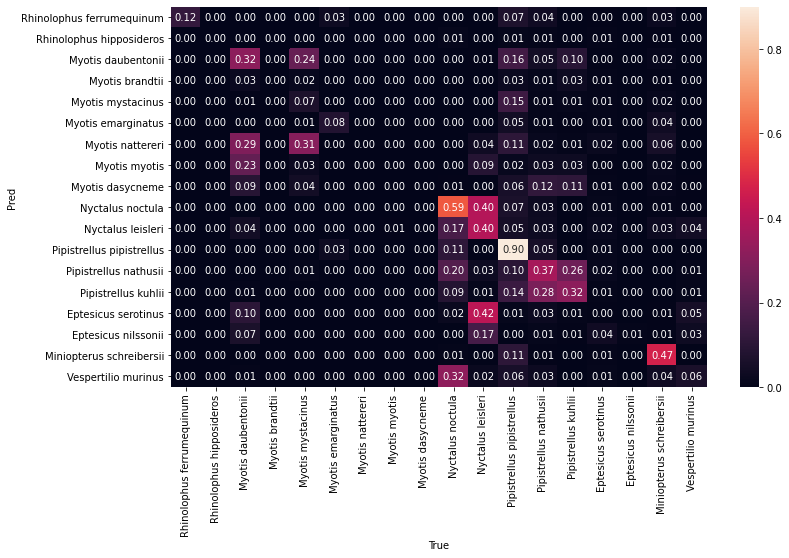

In [25]:
# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred, normalize="all") # normalize{‘true’, ‘pred’, ‘all’}, default=None
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes]) # / np.sum(cf_matrix, axis=-1)
plt.figure(figsize = (12, 7))
s = sn.heatmap(df_cm, annot=True, fmt='.2f')
s.set(xlabel='True', ylabel='Pred')
plt.savefig('BigBAT.png')

In [26]:
corrects = np.equal(Y_pred, Y_true).sum()
single_test_acc = corrects / len(Y_pred)
single_f1 = f1_score(Y_true, Y_pred, average=None).mean()

print("Single test accuracy:", single_test_acc)
print("Single F1-score:", single_f1)

Single test accuracy: 0.36688311688311687
Single F1-score: 0.1911385412506255


In [27]:
wandb.log({
    "mixed_test_acc": mixed_test_acc,
    "mixed_f1_micro": mixed_f1_micro,
    "mixed_f1_macro": mixed_f1_macro,
    "single_test_acc": single_test_acc,
    "single_f1_micro": single_f1,
    "num_params": pytorch_total_params,
})

wandb.finish()

mixed_f1_macro,▁
mixed_f1_micro,▁
mixed_test_acc,▁
num_params,▁
single_f1_micro,▁
single_test_acc,▁
train_acc,▅▅▃▃▂▂▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▃▅▄▅▄▆▆▇▇▆▆▆▅▅█▇██
train_loss,█▆▅▄▄▄▃▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,██▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▄▃▃▃▃▃▄▄▄▄▄▄▅▅▄▄▄▅▅
val_loss,█▆▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mixed_f1_macro,0.21612
